In [1]:
%cd ..

/home/wiss/hofherrf/gitRepos/pendulum_2d


In [2]:
import os
import yaml
import torch
from torchvision import utils
from models.sceneRepresentation import DynamicBackground
from dataset.dataset import DynamicPixelDataset, get_split_dynamic_pixel_data
import matplotlib.pyplot as plt
from util.util import compute_psnr

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

## Qualitative evaluation

In [3]:
path_experiments = os.path.join(
    os.path.abspath(''),
    'experiments',
    '2023-01-28',
    'synthetic',
    'dynamicBackground',
    'wallclock'
)

psnrs = []
path_file = os.path.join(path_experiments, 'results.txt')

# Delete previous result files
if os.path.exists(path_file):
    os.remove(path_file)

# Get all the experiments
for path_experiment in os.scandir(path_experiments):
    # Load Config
    path_conf = os.path.join(path_experiment, '.hydra','config.yaml')
    with open(path_conf) as f:
        cfg = yaml.safe_load(f)

    print("Doing: ", cfg['data']['path_data'])

    # Load Model
    model = DynamicBackground(**cfg['scene'])

    path_ckpt = os.path.join(path_experiment, 'ckpt.pth')
    model.load_state_dict(torch.load(path_ckpt))

    model.to(device)

    # Load Data
    path_data = os.path.join(os.path.abspath(''), 'data',cfg['data']['path_data'])
    data = DynamicPixelDataset(
        path_data,
        skip_timesteps=cfg['data']['skip_timesteps'],
        start_index=cfg['data']['start_idx_test'],
        max_samples=cfg['data']['max_samples_eval']
    )
    H, W = data.get_image_dim()

    # Compute PSNR
    tspan = data.parameters["tspan"].to(device)
    output = model.render_image(W, H, tspan)
    psnr = compute_psnr(output['Image'].cpu(), data.get_full_images())
    psnrs.append(psnr)

    # Write summary file
    with open(path_file, 'a') as f:
        f.write(f"{cfg['data']['path_data']}\n")
        f.write(f"{path_experiment.path}\n")
        f.write(f"PSNR: {psnr}\n")
        f.write("=============================\n\n")

    print(f"PSNR: {psnr}")

    print("Done")
    print("====================================================")

avg_psnr = torch.mean(torch.tensor(psnrs))
print("Results:")
print(f"Avg PSNR: {avg_psnr}")

# Write to results file
with open(path_file, 'a') as f:
    f.write("\nLatex\n")
    f.write(f"{avg_psnr:.2f} & - & -")

Doing:  synthetic_data/wallclock6
PSNR: 30.900354385375977
Done
Doing:  synthetic_data/wallclock6
PSNR: 30.402507781982422
Done
Doing:  synthetic_data/wallclock1
PSNR: 25.49739646911621
Done
Results:
Avg PSNR: 28.933420181274414


## Create Images

In [4]:
path_experiment = os.path.join(
    os.path.abspath(''),
    'experiments',
    '2023-01-28',
    'synthetic',
    'dynamicBackground',
    'wallclock',
    '10-04-56_seq1'
)

path_folder = os.path.join(path_experiment, 'renderings')
if not os.path.isdir(path_folder):
    os.makedirs(path_folder)

# Load Config
path_conf = os.path.join(path_experiment, '.hydra','config.yaml')
with open(path_conf) as f:
    cfg = yaml.safe_load(f)

# Load Model
model = DynamicBackground(**cfg['scene'])

path_ckpt = os.path.join(path_experiment, 'ckpt.pth')
model.load_state_dict(torch.load(path_ckpt))

model.to(device)
print("Model loaded")

Model loaded


Data loaded
tensor([0.0000, 0.2020, 0.4040, 0.6061, 0.8081, 1.0101, 1.2121, 1.4141, 1.6162,
        1.8182, 2.0202, 2.2222, 2.4242, 2.6263, 2.8283, 3.0303, 3.2323, 3.4343,
        3.6364, 3.8384, 4.0404, 4.2424, 4.4444, 4.6465, 4.8485],
       device='cuda:0')


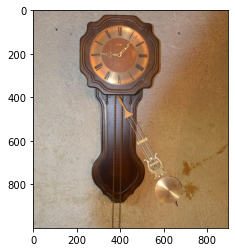

In [6]:
# Train images
# Load Data
path_data = os.path.join(os.path.abspath(''), 'data',cfg['data']['path_data'])
data = DynamicPixelDataset(
    path_data,
    skip_timesteps=cfg['data']['skip_timesteps'],
    max_samples=cfg['data']['max_samples']
)
H, W = data.get_image_dim()
print("Data loaded")

# Render
tspan = data.parameters["tspan"].to(device)
print(tspan)
output = model.render_image(W, H, tspan)
ims = output["Image"].cpu()

plt.imshow(ims[0])

# Train data
inds_to_save = [0, 1]

for i in inds_to_save:
    path = os.path.join(path_folder, f"{i}_train.jpg")
    utils.save_image(ims[i].permute(2, 0, 1), path)
    path = os.path.join(path_folder, f"{i}_gt_train.jpg")
    utils.save_image(data.get_full_images(i).permute(2, 0, 1), path)

Data loaded
tensor([0.0000, 0.1010, 0.3030, 0.5051, 0.7071, 0.9091, 1.1111, 1.3131, 1.5152,
        1.7172, 1.9192, 2.1212, 2.3232, 2.5253, 2.7273, 2.9293, 3.1313, 3.3333,
        3.5354, 3.7374, 3.9394, 4.1414, 4.3434, 4.5455, 4.7475, 4.9495],
       device='cuda:0')
Storing at times 0.9090908765792847 and 4.3434343338012695


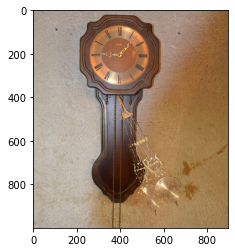

In [7]:
# Test images
# Load Data
path_data = os.path.join(os.path.abspath(''), 'data',cfg['data']['path_data'])
data = DynamicPixelDataset(
    path_data,
    start_index=cfg['data']['start_idx_test'],
    max_samples=cfg['data']['max_samples_eval'],
    skip_timesteps=cfg['data']['skip_timesteps'],
)
H, W = data.get_image_dim()
print("Data loaded")

# Render
tspan = data.parameters["tspan"].to(device)
print(tspan)
output = model.render_image(W, H, tspan)
ims = output["Image"].cpu()

plt.imshow(ims[1])

# Train data
inds_to_save = [5, 22]
print(f"Storing at times {tspan[inds_to_save[0]]} and {tspan[inds_to_save[1]]}")

for i in inds_to_save:
    path = os.path.join(path_folder, f"{i}_test.jpg")
    utils.save_image(ims[i].permute(2, 0, 1), path)
    path = os.path.join(path_folder, f"{i}_gt_test.jpg")
    utils.save_image(data.get_full_images(i).permute(2, 0, 1), path)